In [1]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath
import pickle
import time
from collections import defaultdict
import sklearn

from datetime import datetime, date

from sktensor import dtensor, cp_als
# matplotlib.style.use('ggplot')

from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als


from numpy import linalg as LA

matplotlib.style.use('ggplot')

### Create the tensor

In [65]:
df = pickle.load( open( "dblp_inproceeding_10.p", "rb" ) )

In [22]:
df = df[df.crossref != '']
len(df)

1296663

In [168]:
df.head()

,author,year,crossref
2,Roger King,1993,lncs
4,Yelena Yesha,1993,lncs
5,Jean-Louis Imbert,1994,lncs
6,Jochen D&ouml;rre,1991,lncs
8,Stanley Y. W. Su,1993,lncs


In [169]:
df2 = df

In [170]:
df = df2

In [133]:
selected_index = np.random.choice(len(df), int(0.5*len(df)))
df = df.iloc[selected_index, :]

In [136]:
selected_author = np.random.choice(pd.unique(df.author), int(0.5*len(pd.unique(df.author))))
df = df[df.author.isin(selected_author)]

In [171]:
selected_conf = np.random.choice(pd.unique(df.crossref), int(0.5*len(pd.unique(df.crossref))))
df = df[df.crossref.isin(selected_conf)]

In [172]:
len(df), len(df2)

(469266, 1347279)

### Choose only 10 years

In [73]:
val = 0
df_train = df[df.year>=1991+val]
df_train = df[df.year<=2000+val]
df_test = df[df.year==2001+val]

In [74]:
df_train.reset_index(inplace=True)
df2 = df_train.iloc[:,1:]
df_train = df2
del df2

In [75]:
df_train = df_train[df_train.crossref != '']

In [76]:
df_train.reset_index(inplace=True)
df2 = df_train.iloc[:,1:]
df_train = df2
del df2

In [239]:
#indexes = np.random.choice(range(len(df_train)), int(0.8*len(df_train)))

In [240]:
#df_train = df_train[df_train.index.isin(indexes)]

### More than 10 publications

In [77]:
author_list = pd.unique(df_train.iloc[:,0])

# Get the indexes of each author
authors_indexes = [(element, index) for index, element in enumerate(df_train.author)]
author_index = defaultdict(list)

for k, v in authors_indexes:
    author_index[k].append(v)
    
# Keep the authors with more than 10 publications
author_index_sorted = []
count = 0

for author in author_list : 
    if len(author_index[author]) > 10 :
        author_index_sorted += author_index[author]
        count += len(author_index[author])

In [78]:
df_train = df_train[df_train.index.isin(author_index_sorted)]
df_test = df_test[df_test.author.isin(df_train.author)]
df_test = df_test[df_test.crossref.isin(df_train.crossref)]
df_train.shape, df_test.shape

((355152, 3), (26202, 3))

In [244]:
#del df

### Create the training tensor

In [79]:
author_list = pd.unique(df_train.iloc[:, 0])
conf_list = pd.unique(df_train.iloc[:, 2])
year_list = pd.unique(df_train.iloc[:, 1])

year_list.sort()

author_dic = {element : index for index, element in enumerate(author_list)}
conf_dic =   {element : index for index, element in enumerate(conf_list)}
year_dic =   {element : index for index, element in enumerate(year_list)}

T_train = np.zeros((len(author_list), len(conf_list), len(year_list)))
T_train = dtensor(T_train)

In [80]:
# Going through the dataframe
t_temp = time.time()
i = 0

L = len(zip(df_train.author, df_train.crossref, df_train.year))

for a, c, y in zip(df_train.author, df_train.crossref, df_train.year):
    if i % 100000 == 1:
        print('%d/%d (df.author, df.crossref, df.year) treated - %.0f seconds elapsed') %(i, L, time.time() - t_temp)
        
    # Finding the corresponding index in the tensor
    a_ind = author_dic[a]
    c_ind = conf_dic[c]
    y_ind = year_dic[y]
    
    # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
    T_train[a_ind, c_ind, y_ind] += 1
    
    i +=1

print time.time()-t_temp    

1/355152 (df.author, df.crossref, df.year) treated - 0 seconds elapsed
100001/355152 (df.author, df.crossref, df.year) treated - 1 seconds elapsed
200001/355152 (df.author, df.crossref, df.year) treated - 1 seconds elapsed
300001/355152 (df.author, df.crossref, df.year) treated - 1 seconds elapsed
1.51735806465


In [81]:
# Logarithmic Transformation
nonz = T_train.nonzero()
for ind in range(len(nonz[0])):
    i_ind = nonz[0][ind]
    j_ind = nonz[1][ind] 
    k_ind = nonz[2][ind]
    
    T_train[i_ind, j_ind, k_ind] = 1 + np.log(T_train[i_ind, j_ind, k_ind]) 

In [82]:
del year_dic

### Create the test tensor

In [83]:
author_list_train = author_list
conf_list_train = conf_list
author_dic_train = author_dic
conf_dic_train = conf_dic

T_test = np.zeros((len(author_list_train), len(conf_list_train)))

In [84]:
# Going through the dataframe
for a, c in zip(df_test.author, df_test.crossref):
    # Finding the corresponding index in the tensor
    a_ind = author_dic_train[a]
    c_ind = conf_dic_train[c]
    
    # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
    T_test[a_ind, c_ind] = 1


In [85]:
del author_list_train, conf_list_train, author_list, conf_list, author_dic, conf_dic

In [86]:
T_train.shape, T_test.shape

((17243, 1109, 10), (17243, 1109))

In [59]:
len(pd.unique(df_test.author)), len(pd.unique(df_test.crossref))

(2620, 149)

In [66]:
for i in range(7) :
    print len(pd.unique(df.ix[df.year == 2001+i, 2])), len(pd.unique(df.ix[df.year == 2001+i, 0]))

688 28431
759 31534
896 35469
1038 39176
1183 41408
1237 41759
1312 40922


In [67]:
df2 = df[df.crossref != '']

In [71]:
for val in range(7) :
    
    df_train = df[df.year>=1991+val]
    df_train = df[df.year<=2000+val]
    df_test = df[df.year==2001+val]

    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    df_train = df_train[df_train.crossref != '']

    df_train.reset_index(inplace=True)
    df2 = df_train.iloc[:,1:]
    df_train = df2
    del df2

    author_list = pd.unique(df_train.iloc[:,0])

    # Get the indexes of each author
    authors_indexes = [(element, index) for index, element in enumerate(df_train.author)]
    author_index = defaultdict(list)

    for k, v in authors_indexes:
        author_index[k].append(v)

    # Keep the authors with more than 10 publications
    author_index_sorted = []
    count = 0

    for author in author_list : 
        if len(author_index[author]) > 10 :
            author_index_sorted += author_index[author]
            count += len(author_index[author])

    df_train = df_train[df_train.index.isin(author_index_sorted)]
    df_test = df_test[df_test.author.isin(df_train.author)]
    df_test = df_test[df_test.crossref.isin(df_train.crossref)]
    df_train.shape, df_test.shape

    author_list = pd.unique(df_train.iloc[:, 0])
    conf_list = pd.unique(df_train.iloc[:, 2])
    year_list = pd.unique(df_train.iloc[:, 1])

    year_list.sort()

    author_dic = {element : index for index, element in enumerate(author_list)}
    conf_dic =   {element : index for index, element in enumerate(conf_list)}
    year_dic =   {element : index for index, element in enumerate(year_list)}

    T_train = np.zeros((len(author_list), len(conf_list), len(year_list)))
    T_train = dtensor(T_train)

    # Going through the dataframe
    for a, c, y in zip(df_train.author, df_train.crossref, df_train.year):
        # Finding the corresponding index in the tensor
        a_ind = author_dic[a]
        c_ind = conf_dic[c]
        y_ind = year_dic[y]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_train[a_ind, c_ind, y_ind] += 1

    # Logarithmic Transformation
    nonz = T_train.nonzero()
    for ind in range(len(nonz[0])):
        i_ind = nonz[0][ind]
        j_ind = nonz[1][ind] 
        k_ind = nonz[2][ind]
        T_train[i_ind, j_ind, k_ind] = 1 + np.log(T_train[i_ind, j_ind, k_ind]) 

    author_list_train = author_list
    conf_list_train = conf_list
    author_dic_train = author_dic
    conf_dic_train = conf_dic

    T_test = np.zeros((len(author_list_train), len(conf_list_train)))

    # Going through the dataframe
    for a, c in zip(df_test.author, df_test.crossref):
        # Finding the corresponding index in the tensor
        a_ind = author_dic_train[a]
        c_ind = conf_dic_train[c]
        # Modifying the tensor value for the tuple (i_ind, j_ind, k_ind)
        T_test[a_ind, c_ind] = 1

    print val, len(pd.unique(df_test.author)), len(pd.unique(df_test.crossref))

 0 10084 523
1 11919 573
2 14309 673
3 17577 798
4 21475 939
5 25364 1015
6 29390 1109


## Tensor Factorization

In [87]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T_train) / float(T_train.shape[0] * T_train.shape[1] * T_train.shape[2])

### CanDecom/ParaFac (CP) Decomposition

In [23]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

### Collapsed Unweighted Tensor  
Precision-Recall for several values of K

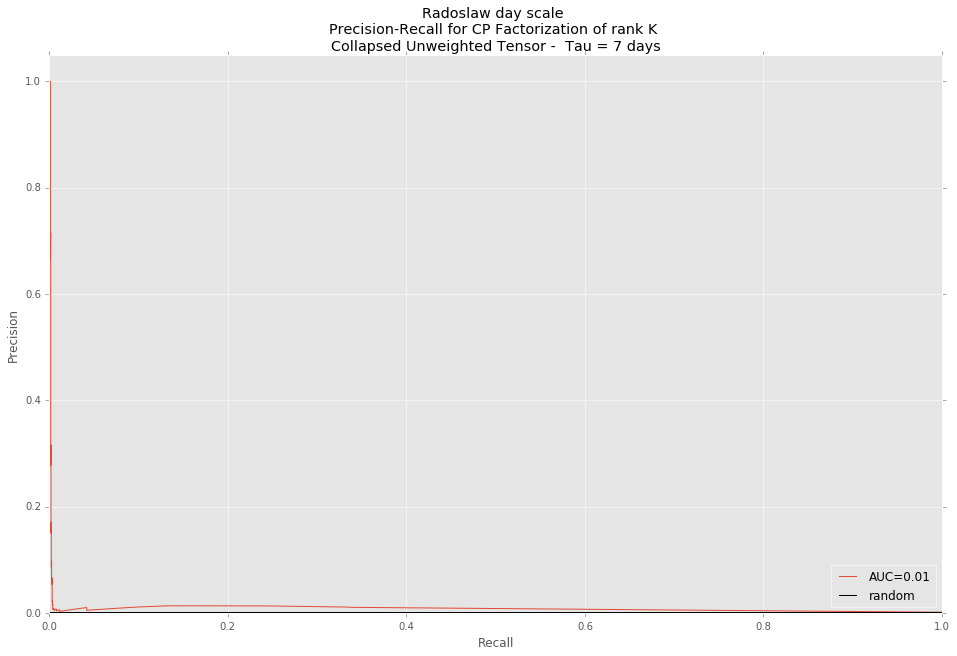

In [134]:
K_list = [1, 5, 10, 30, 50]
S = np.zeros((T_train.shape[0], T_train.shape[1]))
tau_list= [2]

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    # Initialization
    precision = dict()
    recall = dict()
    average_precision = dict()
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # CP Decomposition
        P, fit, itr, exectimes = cp_als(T_train, K, init='random')
        A, B, C = P.U
        # CP Scoring
        gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
        Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
        for i in range(Sk.shape[0]) :
            for j in range(Sk.shape[1]) :
                Sk[i,j] = float(Sk[i,j])
        S += Sk/LA.norm(Sk, 'fro')

y_score = S.flatten()
y_test = (1*np.array(T_test[:, :] >= 1)).flatten()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)    

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \nCollapsed Unweighted Tensor -  Tau = %d years' %(tau))
plt.savefig('Radoslaw day cp_roc_cut_%d.pdf' %(tau))    

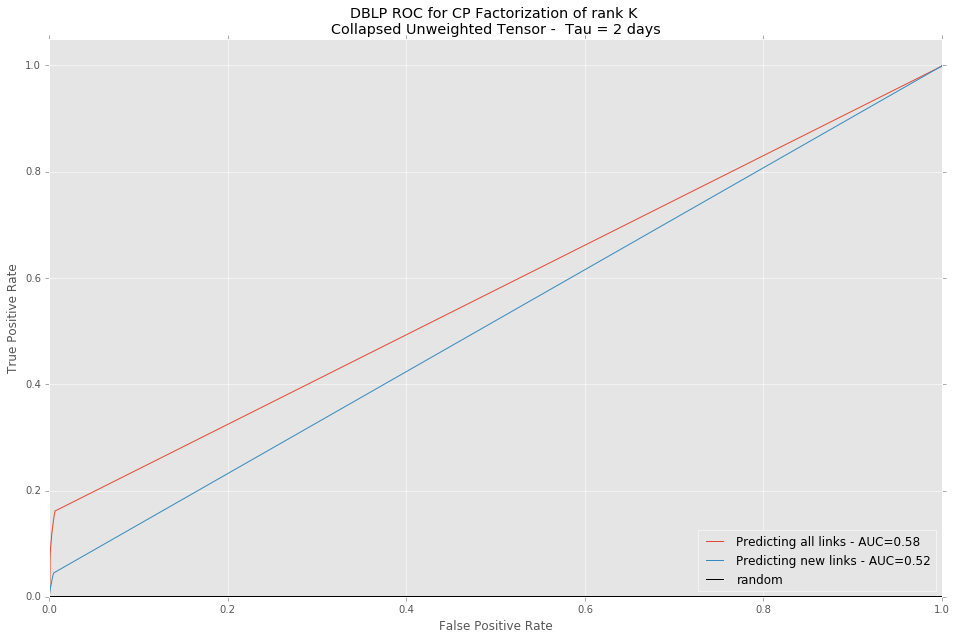

In [46]:
S_test = (1*np.array(T_test[:, :] >= 1))
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_pred = np.zeros((S.shape[0], S.shape[1]))
S_test_all = np.zeros((S.shape[0], S.shape[1]))

#S_test = np.zeros((CUT.shape[0], CUT.shape[1]))

tau = 2
K_list = [5]
#,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
    S_test = (1*np.array(T_test[:, :] >= 1))
    if i==0 :
        for K_ind in range(len(K_list)):
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
            Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
            S+= Sk/LA.norm(Sk, 'fro')
        y_test = S_test.flatten()
        y_score = S.flatten()
    else :
        nonz = T_train.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score = S.flatten()
        y_test = S_test.flatten()
            
    # ROC 
    FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f}' .format(AUC[0]))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}'.format(AUC[1]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for CP Factorization of rank K \nCollapsed Unweighted Tensor -  Tau = %d years' %(tau))
plt.savefig('DBLP TSVD_roc_cut.pdf')   

### Exponential Smoothing  
Precision-Recall for several values of K

In [45]:
#K_list = [1, 5, 10, 30, 50]
K_list = [5]
#tau_list = [1, 7, 20]
tau = 2
#alpha_list = [0.2, 0.5, 0.8]
alpha_list = [0.3] 

FPR = []
TPR = []
AUC = []

for i in range(2) :
    for alpha_ind in range(len(alpha_list)):
        S_test = (1*np.array(T_test[:, :] >= 1))
        # Choice of alpha
        alpha = alpha_list[alpha_ind]
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            t_1 - t_0 = 10
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = T_train.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        # ROC 
        FPR_, TPR_, _ = sklearn.metrics.roc_curve(y_test, y_score)
        FPR += [FPR_]
        TPR += [TPR_]
        AUC += [sklearn.metrics.roc_auc_score(y_test, y_score)]
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f} - Alpha=%d' .format(AUC[0]) %(alpha))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}- Alpha=%d'.format(AUC[1])%(alpha))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('Radoslaw day scale \nPrecision-Recall for CP Factorization of rank K \
              \nCollapsed Weighted Tensor -  Alpha = %.2f - Tau = %d years - Exponential Smoothing' %(alpha, tau))
plt.savefig('Radoslaw day cp_roc_cwt_%.2f_%d Exponential Smoothing.pdf' %(alpha, tau))    

NameError: name 't_1' is not defined

# TSVD, Katz, TKatz

## Collapsed unweighted tensor

In [268]:
CUT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))

for k in range(T_train.shape[2]):
    CUT = CUT + T_train[:,:,k]

### TSVD  
Precision-Recall for several values of K

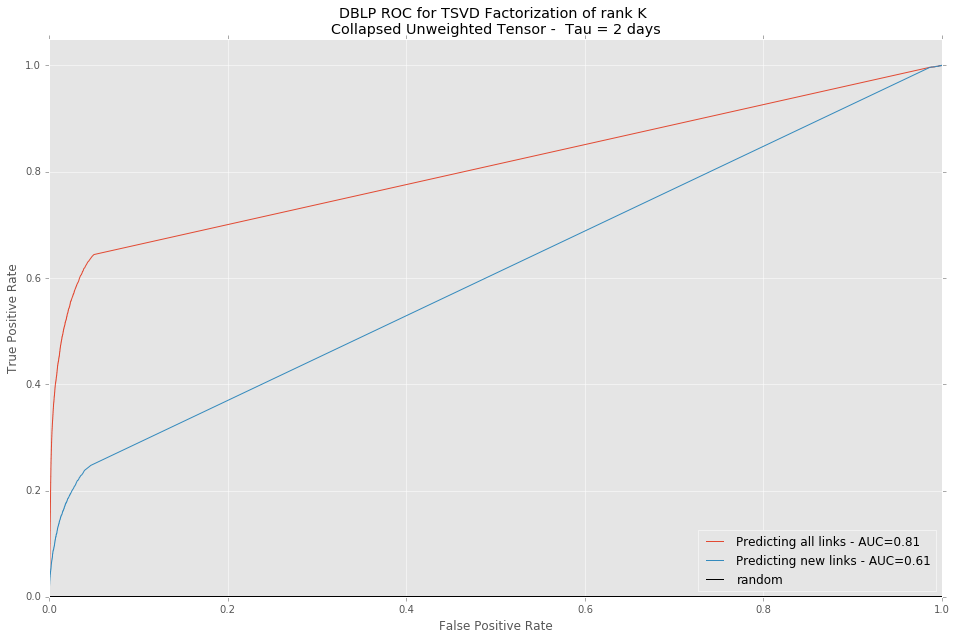

In [31]:
S = np.zeros((CUT.shape[0], CUT.shape[1]))

K_list = [1,5,10,30,50]
FPR = []
TPR = []
AUC = []

for i in range(2) :
    S_test = (1*np.array(T_test[:, :] >= 1))
    if i==0 :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        y_score = S.flatten()
        y_test = S_test.flatten()
    else :
        nonz = CUT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_score = S.flatten()
        y_test = S_test.flatten()

    # ROC 
    FPR_, TPR_, _ = sklearn.metrics.roc_curve(y_test, y_score)
    FPR += [FPR_]
    TPR += [TPR_]
    AUC += [sklearn.metrics.roc_auc_score(y_test, y_score)]


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f}' .format(AUC[0]))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}'.format(AUC[1]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TSVD Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('DBLP TSVD_roc_cut.pdf')   

### BipartiteKatz  
Precision-Recall for several values of Beta

In [269]:
beta_list= [0.001, 0.01, 0.1]
U, Sigma, V= np.linalg.svd(CUT, full_matrices=False)

theta = 0.2
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
    for B_ind in range(len(beta_list)):
        S_test = (1*np.array(T_test[:, :] >= 1))
        beta = beta_list[B_ind]
        gamma = []
        for j in range(len(Sigma)) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        # Katz Scoring
        S = np.dot(np.dot(U,np.diag(gamma)),V)
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        # ROC 
        FPR[i+beta], TPR[i+beta], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i+beta] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i==0 :
        for beta in beta_list:
            plt.plot(FPR[beta], TPR[beta], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                                   .format(AUC[beta]) %(beta))
    else :
        for beta in beta_list:
            plt.plot(FPR[B_ind+i], TPR[B_ind+i], label= 'Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                                   .format(AUC[beta+i]) %(beta))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for BKatz Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('DBLP BKatz_roc_cut.pdf')   

KeyboardInterrupt: 

### TBKatz  
Precision-Recall for several values of Beta

In [ ]:
beta_list= [0.001, 0.01, 0.1]
K_list = [1,5,10,30,50]

# Initialization
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        S_test = (1*np.array(T_test[:, :] >= 1))
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            gamma = []
            for j in range(K) :
                gamma += [1/(1-beta*Sigma[j]) - 1]
            Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
            S+= Sk/LA.norm(Sk, 'fro')
            
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten() 

        #ROC
        FPR[i+B_ind], TPR[i+B_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i+B_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i==0 :
        for B_ind in range(len(beta_list)):
            plt.plot(FPR[B_ind], TPR[B_ind], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f'\
                                                             .format(AUC[B_ind]) %(beta_list[B_ind]))
    else :
        for B_ind in range(len(beta_list)):
            plt.plot(FPR[B_ind+i], TPR[B_ind+i], label='Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                             .format(AUC[B_ind+i]) %(beta_list[B_ind]))
 
    
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TBKatz \nCollapsed Unweighted Tensor')
plt.savefig('DBLP TBKatz_roc_cut.pdf')   

## Collapsed weighted tensor

In [118]:
CWT = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))
theta = 0.2
K = T_train.shape[2]

for k in range(T_train.shape[2]):
    CwT = CWT + ((1-theta)**(K - k))*T_train[:,:,k]

In [119]:
# Create a np.array matrix instead of the sklearn tensor
C = np.zeros((T_train[:,:,0].shape[0], T_train[:,:,0].shape[1]))

In [120]:
for i in range(CWT.shape[0]) :
    for j in range(CWT.shape[1]) :
        C[i,j] = CWT[i,j]

In [121]:
CWT = C
del C

In [122]:
S_test = (1*np.array(T_test[:, :] >= 1))

### TSVD  
Precision-Recall for several values of K

[  0.00000000e+00   5.23506159e-08   1.04701232e-07 ...,   9.99999895e-01
   9.99999948e-01   1.00000000e+00] [ 0.  0.  0. ...,  1.  1.  1.] 0.479578540463
[  0.00000000e+00   5.23506159e-08   1.04701232e-07 ...,   9.99999895e-01
   9.99999948e-01   1.00000000e+00] [ 0.  0.  0. ...,  1.  1.  1.] 0.479578540463


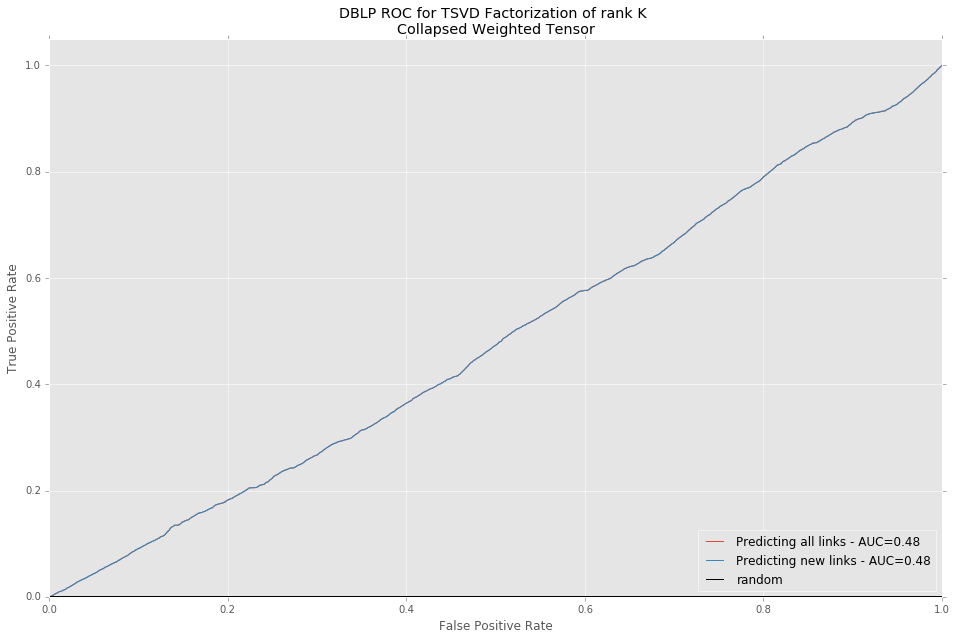

In [123]:
S = np.zeros((CWT.shape[0], CWT.shape[1]))

tau = 2
K_list = [5,10,30,50]
FPR = dict()
TPR = dict()
AUC = dict()

for i in range(2) :
    S_test = (1*np.array(T_test[:, :] >= 1))
    if i==0 :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        y_test = S_test.flatten()
        y_score = S.flatten()
    else :
        nonz = CWT.nonzero()
        for ind in range(len(nonz[0])):
            i_ind = nonz[0][ind]
            j_ind = nonz[1][ind] 
            S[i_ind, j_ind] = 0
        y_test = S_test.flatten()
        y_score = S.flatten()
    # ROC 
    FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
    print FPR[i], TPR[i], AUC[i]
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
plt.plot(FPR[0], TPR[0], label='Predicting all links - AUC={0:0.2f}' .format(AUC[0]))
plt.plot(FPR[1], TPR[1], label= 'Predicting new links - AUC={0:0.2f}'.format(AUC[1]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TSVD Factorization of rank K \nCollapsed Weighted Tensor')
plt.savefig('DBLP TSVD_roc_cwt.pdf')   

### BKatz
Precision-Recall for several values of Beta

In [124]:
beta_list= [0.001, 0.1, 0.3]
U, Sigma, V= np.linalg.svd(CWT, full_matrices=False)

theta = 0.2
FPR = dict()
TPR = dict()
AUC = dict()

for i in range(2) :
    for B_ind in range(len(beta_list)):
        S_test = (1*np.array(T_test[:, :] >= 1))
        beta = beta_list[B_ind]
        gamma = []
        for j in range(len(Sigma)) :
            gamma += [1/(1-beta*Sigma[j]) - 1]
        # Katz Scoring
        S = np.dot(np.dot(U,np.diag(gamma)),V)
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            y_old_score = y_score
            y_old_test = y_test
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()
          
        # ROC 
        FPR[i+beta], TPR[i+beta], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i+beta] = sklearn.metrics.roc_auc_score(y_test, y_score)
    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i==0 :
        for beta in beta_list:
            plt.plot(FPR[beta], TPR[beta], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                                     .format(AUC[beta]) %(beta))
    else :
        for beta in beta_list:
            plt.plot(FPR[beta+i], TPR[beta+i], label='Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                                     .format(AUC[beta+i]) %(beta))
    
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for BKatz Factorization of rank K \nCollapsed Weighted Tensor')
plt.savefig('DBLP BKatz_roc_cwt.pdf')  

KeyboardInterrupt: 

### TBKatz
Precision-Recall for several values of Beta

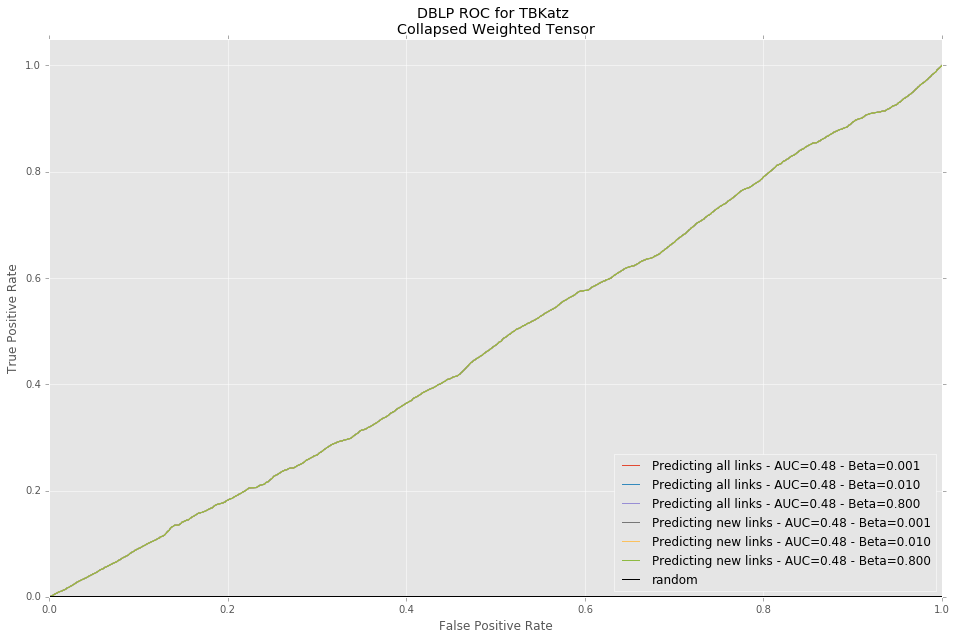

In [274]:
beta_list= [0.001, 0.01, 0.8]
S_test_all = np.zeros((S.shape[0], S.shape[1]))
K_list = [1,5,10,30,50]

# Initialization
FPR = {}
TPR = {}
AUC = {}

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        S_test = (1*np.array(T_test[:, :] >= 1))
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            gamma = []
            for j in range(K) :
                gamma += [1/(1-beta*Sigma[j]) - 1]
            Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
                S_test[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()
            
        #ROC
        FPR[i+beta], TPR[i+beta], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i+beta] = sklearn.metrics.roc_auc_score(y_test, y_score)

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i==0 :
        for beta in beta_list:
            plt.plot(FPR[beta], TPR[beta], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f'\
                                                                     .format(AUC[beta]) %(beta))
    else :
        for beta in beta_list:
            plt.plot(FPR[beta+i], TPR[beta+i], label='Predicting new links - AUC={0:0.2f} - Beta=%0.3f'\
                                                                     .format(AUC[beta+i]) %(beta))
 
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP ROC for TBKatz \nCollapsed Weighted Tensor')
plt.savefig('DBLP TBKatz_roc_cwt.pdf')   

[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0.          0.          0.        ] 0.00100769394822
[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0.          0.          0.        ] 0.00100769394822
[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0.          0.          0.        ] 0.00100769394822
[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0.          0.          0.        ] 0.00100769394822
[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0.          0.          0.        ] 0.00100769394822
[ 0.00107289  0.00107284  0.00107284 ...,  0.          0.          1.        ] [ 1.          0.99995126  0.99995126 ...,  0. 

KeyboardInterrupt: 

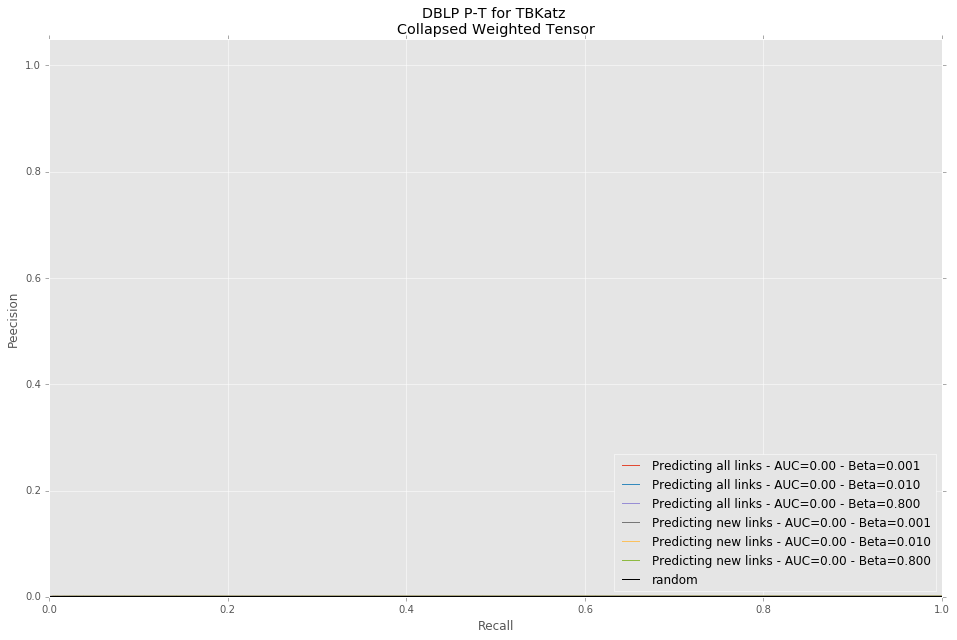

In [276]:
beta_list= [0.001, 0.01, 0.8]
S_test_all = np.zeros((S.shape[0], S.shape[1]))
K_list = [1,5,10,30,50]

# Initialization
precision = dict()
recall = dict()
aver_ = dict()


    for B_ind in range(len(beta_list)) :
        S_test = (1*np.array(T_test[:, :] >= 1))
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            gamma = []
            for j in range(K) :
                gamma += [1/(1-beta*Sigma[j]) - 1]
            Sk = np.dot(U,np.dot(np.diag(gamma), Vt))
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
                S_test[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()
            
        # Precision-Recall
        precision[i+beta], recall[i+beta], _ = precision_recall_curve(y_test, y_score)
        aver_[i+beta] = average_precision_score(y_test, y_score)
        print precision[i+beta], recall[i+beta], aver_[i+beta]
        
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i==0 :
        for beta in beta_list:
            plt.plot(recall[beta], precision[beta], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f'\
                                                                     .format(aver_[beta]) %(beta))
    else :
        for beta in beta_list:
            plt.plot(recall[beta+i], precision[beta+i], label='Predicting new links - AUC={0:0.2f} - Beta=%0.3f'\
                                                                     .format(aver_[beta+i]) %(beta))
 
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('Recall')
plt.ylabel('Peecision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('DBLP P-T for TBKatz \nCollapsed Weighted Tensor')
plt.savefig('DBLP TBKatz_pr_cwt.pdf')   